<a href="https://colab.research.google.com/github/Amine-kouki/Intent-Classifier-AI-Agent/blob/main/Data_cleanning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading and extracting thr JSON date

In [89]:
import json
import os

try:
    with open('intents_dataset.json', 'r') as f:
        data = json.load(f)
        print("Data loaded successfully.")
        print(data)  # Print first two intents for inspection

except FileNotFoundError:
    print("Error: The file was not found.")
except json.JSONDecodeError:
    print("Error: Failed to decode JSON from the file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



Data loaded successfully.
{'software_issue': {'cannot_login': ["I can't log in", "My password isn't working", "I'm locked out of my account", 'It says my credentials are invalid', 'I forgot my password', "My login isn't being accepted", "The system won't let me in", "I keep getting an 'access denied' message", 'I need a password reset', 'It says my account is disabled', "I'm stuck on the login screen", "My two-factor authentication isn't working", "I get a 'wrong username or password' error", "I changed my password and now it doesn't work", 'The login page just keeps refreshing'], 'application_crash': ['The program keeps crashing', 'My software keeps closing unexpectedly', 'I keep getting an error message and then it closes', 'It freezes and I have to force quit', 'The application is not responding', "It just shuts down randomly while I'm working", 'I get a pop-up that says [Application] has stopped working', 'My screen goes grey and I have to restart the program', 'It hangs every time

In [90]:
import pandas as pd

rows = []
for category, intents in data.items():
    for intent , messages in intents.items():
        for messages in messages :
            rows.append({'category': category, 'intent': intent, 'text': messages})

df = pd.DataFrame(rows)

print(df.head())

         category        intent                                text
0  software_issue  cannot_login                      I can't log in
1  software_issue  cannot_login           My password isn't working
2  software_issue  cannot_login        I'm locked out of my account
3  software_issue  cannot_login  It says my credentials are invalid
4  software_issue  cannot_login                I forgot my password


#### Basic normalization

In [91]:
print(df.columns)

Index(['category', 'intent', 'text'], dtype='object')


In [92]:
import re
import pandas as pd

def normalize_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = ' '.join(text.split()).strip()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^\w\s\.\,\!\?\'\d\-\/]+', ' ', text)
        text = ' '.join(text.split()).strip()
    return text

df['cleaned_text'] = df['text'].apply(normalize_text)

df.to_csv('cleaned_intents_dataframe.csv', index=False)

print("DataFrame head (showing original vs. cleaned text):")
print(df[['text', 'cleaned_text', 'intent']].head())
print("\nDataFrame info:")
df.info()

DataFrame head (showing original vs. cleaned text):
                                 text                        cleaned_text  \
0                      I can't log in                      i can't log in   
1           My password isn't working           my password isn't working   
2        I'm locked out of my account        i'm locked out of my account   
3  It says my credentials are invalid  it says my credentials are invalid   
4                I forgot my password                i forgot my password   

         intent  
0  cannot_login  
1  cannot_login  
2  cannot_login  
3  cannot_login  
4  cannot_login  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category      446 non-null    object
 1   intent        446 non-null    object
 2   text          446 non-null    object
 3   cleaned_text  446 non-null    object
dtyp

### Setting up the model

In [4]:
%pip install -q transformers datasets scikit-learn accelerate

In [93]:
# imports
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer , AutoModelForSequenceClassification , TrainingArguments , Trainer , pipeline
import numpy as np
from sklearn.metrics import accuracy_score , f1_score , classification_report



* from ***datasets*** import Dataset: Imports the Hugging Face ***Dataset*** tool. This is a special, high-speed data format required for training the model.
* ***AutoTokenizer***: The tool that breaks text into numbers.
* ***AutoModelForSequenceClassification***: The specific "brain" designed for categorizing text.
* ***TrainingArguments***: A configuration list (rules) for training.
* ***Trainer***: The "manager" that actually runs the training loop.

---









### Loading and Labeling

In [94]:
# load data
try:
    df = pd.read_csv('cleaned_intents_dataframe.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The file was not found.")

# create label Maps
try :
    unique_intents = df['intent'].unique().tolist()
    label2id = {intent : i for i , intent in enumerate(unique_intents)}
    id2label = {i : intent for i , intent in enumerate(unique_intents)}
    print("Label maps created successfully.")
except Exception as e :
    print(f"An unexpected error occurred: {e}")

# create dataset
try :
    df['labels'] = df['intent'].map(label2id)
    print("labels applyed")
except Exception as e :
    print(f"An unexpected error occurred: {e}")

Data loaded successfully.
Label maps created successfully.
labels applyed


##### ***`df['intent'].unique().tolist()`***: Looks at the 'intent' column, finds every unique category (e.g., "login_issue", "refund"), and puts them in a simple list.

##### ***`id2label = ...`***: Creates the reverse dictionary mapping numbers back to names. The model outputs numbers, so we need this to translate the answer back to English later.

##### ***`label2id = ...`***: This uses a Python dictionary comprehension. It creates a "dictionary" that maps names to numbers.

##### ***`df['labels'] = ...`***: Creates a new column called 'labels' in your table. It looks up every text intent in the label2id dictionary and writes down the corresponding number (0, 1, 2, etc.).


#### Dataset Creation & Splitting

In [95]:
# create hugging face Datasets
ds = Dataset.from_pandas(df[['cleaned_text' , 'labels']])

# split data
ds = ds.train_test_split(test_size = 0.2)

##### ***`Dataset.from_pandas(...)`***: Converts your pandas table into a Hugging Face Dataset object. We selects only the columns we need: the text (cleaned_text) and the answers (labels).

##### ***`ds.train_test_split(test_size=0.2)`***: Randomly cuts your data into two piles:
  - **Train (80%)**: Used to teach the model.
  - **Test (20%)**: Hidden from the model during training, used later to check if it actually learned or just memorized.

#### Tokenization

In [96]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
  return tokenizer(examples["cleaned_text"], padding="max_length", truncation=True, max_length=128)

tokenized_ds = ds.map(
    tokenize_function,
    batched=True,
    remove_columns=['cleaned_text']
    )

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

##### ***`model_checkpoint = ...`***: A string storing the exact name of the model we want to download from the Hugging Face Hub.

##### ***`tokenizer = ...`***: Downloads the specific vocabulary for DistilBERT. It knows that "refund" = ID 4852 (hypothetically).

##### ***`padding="max_length"`***: "Stretches" short sentences. If a sentence is 5 words, it adds 123 "pad" tokens (zeros) so it reaches the length of 128. Computers like uniform shapes.

##### ***`truncation=True`***: "Cuts" long sentences. If a sentence is 200 words, it chops off the end to fit the 128 limit.

##### ***`ds.map(..., batched=True)`***: Runs the function we just defined over the entire dataset at once (in batches). This is much faster than a for loop.

### Model setup

In [97]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(unique_intents),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### ***`AutoModelForSequenceClassification`***: Loads the pre-trained DistilBERT model.

##### ***`num_labels=len(unique_intents)`***: This is the crucial part. DistilBERT normally doesn't know how many categories you have. This line effectively "deletes" the final layer of the neural network and replaces it with a new layer that has exactly as many output nodes as you have intents (e.g., 15 outputs for 15 intents).

##### ***`id2label / label2id`***: We save the dictionaries inside the model configuration. This ensures that when you save the model and load it later, it still remembers that 0 means "login_issue".

#### Accuracy Metric

In [98]:
def compure_mertrics(eval_pred):
  logits,labels = eval_pred
  predictions = np.argmax(logits,axis=-1)
  accuracy = accuracy_score(labels , predictions)
  f1 = f1_score(labels , predictions , average='weighted')
  return {"accuracy" : accuracy , "f1" : f1}

#### Training and execution

In [ ]:
training_args = TrainingArguments(
    output_dir="my_intent_classifier/1",
    learning_rate=1e-5,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    warmup_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compure_mertrics,
)

trainer.train()

/tmp/ipython-input-964532280.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.489232,0.622222,0.600547
2,No log,1.472875,0.611111,0.592169
3,No log,1.455862,0.600000,0.579250
4,No log,1.432912,0.611111,0.581203
5,No log,1.419756,0.611111,0.584907
6,No log,1.407955,0.611111,0.584907
7,No log,1.375530,0.588889,0.569559
8,No log,1.375329,0.611111,0.591534
9,No log,1.373453,0.611111,0.591534
10,No log,1.366365,0.611111,0.584907


##### ***`learning_rate=2e-5`***: Controls how "fast" the model changes its mind. A very small number (0.00002) is standard for fine-tuning; if it's too high, the model forgets everything it already knew.

##### ***`num_train_epochs=5`***: One "epoch" is one full cycle through your entire training dataset. We are telling it to read the whole book 5 times.

##### ***`load_best_model_at_end=True`***: If the model performs best at Epoch 3 but gets worse at Epoch 5 (overfitting), this ensures the final model you get back is the "best" version (Epoch 3).

##### ***`Trainer(...)`***: This initializes the manager. We hand it the model (the student), the arguments (the syllabus), and the datasets (the textbooks).

##### ***`trainer.train()`***: The command that actually starts the process. The GPU spins up, and the progress bar appears.

Note: 'loss' column not found in log history, training loss cannot be plotted.


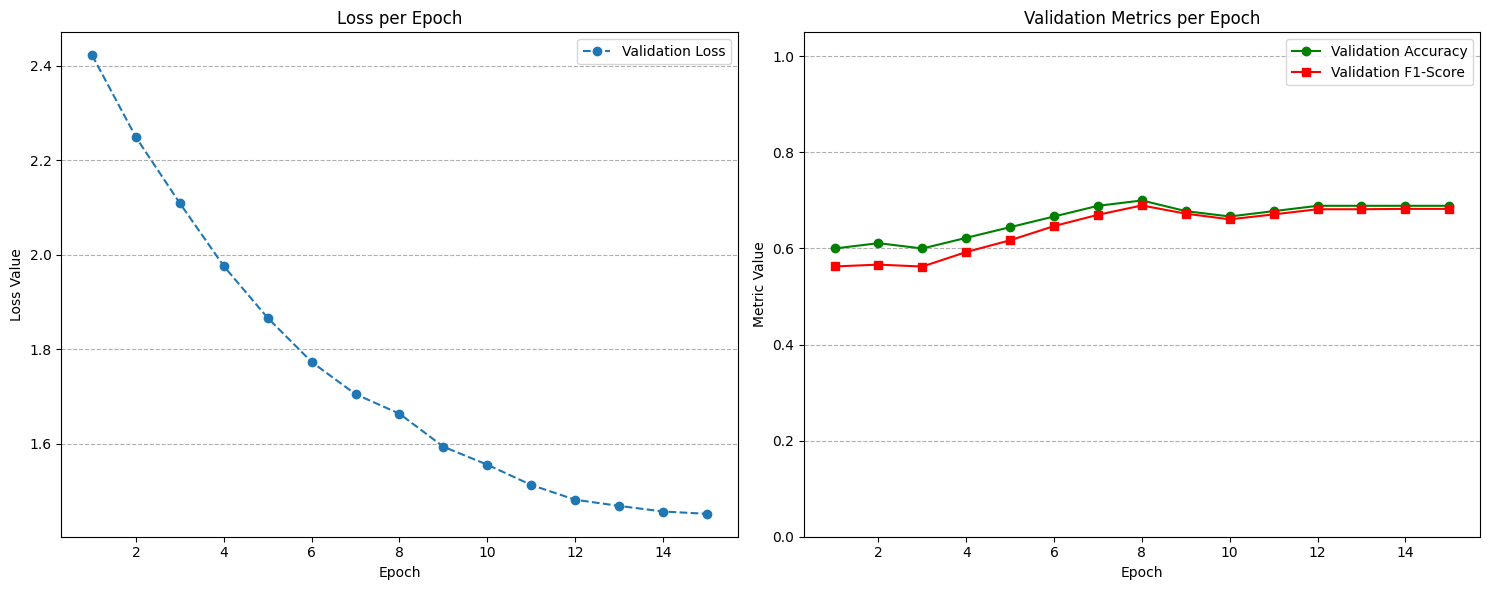

In [50]:
# @title
import matplotlib.pyplot as plt

# 1. Get the log history from the completed trainer
log_history = trainer.state.log_history

# 2. Filter the logs to extract only evaluation metrics (run per epoch)
df_logs = pd.DataFrame(log_history)
df_metrics = df_logs.dropna(subset=['eval_loss']).reset_index(drop=True)

# 3. Create the Visualization Charts
plt.figure(figsize=(15, 6))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1)
plt.plot(df_metrics.index + 1, df_metrics['eval_loss'], label='Validation Loss', marker='o', linestyle='--')

# Extract training loss points, check if 'loss' column exists
if 'loss' in df_logs.columns:
    # Filter for training loss entries
    train_logs_for_plot = df_logs[df_logs['loss'].notna()]
    if not train_logs_for_plot.empty:
        # Plot training loss using its own epoch values (which might be fractional)
        plt.plot(train_logs_for_plot['epoch'], train_logs_for_plot['loss'], label='Training Loss', marker='.', linestyle='-', alpha=0.7, color='blue')
    else:
        print("Note: No training loss entries found in log history, only validation loss is plotted.")
else:
    print("Note: 'loss' column not found in log history, training loss cannot be plotted.")

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(axis='y', linestyle='--')

# --- Plot 2: Accuracy/F1 Score ---
plt.subplot(1, 2, 2)
plt.plot(df_metrics.index + 1, df_metrics['eval_accuracy'], label='Validation Accuracy', marker='o', color='green')
plt.plot(df_metrics.index + 1, df_metrics['eval_f1'], label='Validation F1-Score', marker='s', color='red')
plt.title('Validation Metrics per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

#### Saving the model

In [72]:
MODEL_SAVE_PATH = "./final_intent_classifier_model"
trainer.model.save_pretrained(MODEL_SAVE_PATH)

trainer.tokenizer.save_pretrained(MODEL_SAVE_PATH)

print(f"Model and Tokenizer successfully saved to: {MODEL_SAVE_PATH}")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Model and Tokenizer successfully saved to: ./final_intent_classifier_model


#### Pipelining the model

In [74]:
MODEL_LOAD_PATH = "./final_intent_classifier_model"

model = AutoModelForSequenceClassification.from_pretrained(MODEL_LOAD_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_LOAD_PATH)
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 # Use 0 for GPU, or -1 for CPU
)
new_query ="my screen is white."
prediction = classifier(new_query)
print(f"User Query: {new_query}")
print("-" * 50)
print(f"predected intent: {prediction[0]['label']}")
print(f"confidence score: {prediction[0]['score']:.4f}")

Device set to use cuda:0


User Query: my screen is white.
--------------------------------------------------
predected intent: blue_screen_of_death 
confidence score: 0.1688


#### Classification Report

In [76]:
prediction_output = trainer.predict(tokenized_ds["test"])
logits = prediction_output.predictions
true_labels = prediction_output.label_ids
predicted_labels = np.argmax(logits, axis=-1)
target_names = unique_intents
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=target_names,
    digits=3
    )
print("-"*50)
print("classification report")
print("-"*50)
print(report)

--------------------------------------------------
classification report
--------------------------------------------------
                                precision    recall  f1-score   support

                  cannot_login      0.200     0.500     0.286         2
             application_crash      0.500     1.000     0.667         2
             slow_performance       0.333     0.500     0.400         2
             email_sync_issue       1.000     0.400     0.571         5
            no_internet_access      0.500     1.000     0.667         2
         printer_driver_error       0.750     0.750     0.750         4
        vpn_connection_failed       0.000     0.000     0.000         0
      software_not_responding       0.000     0.000     0.000         2
           forgotten_password       0.000     0.000     0.000         2
              file_corruption       1.000     0.800     0.889         5
operating_system_update_error       0.500     0.333     0.400         3
   cannot_a

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [ ]:
from google.colab import drive

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define your persistent working directory path
# This is where all your models and processed data will be saved.
# Create this folder manually in your Drive if it doesn't exist.
BASE_PATH = '/content/drive/MyDrive/NLP_Intent_Classifier_Project'
!mkdir -p "$BASE_PATH"
print(f"Base persistence path set to: {BASE_PATH}")